In [1]:
import ROOT
import numpy as np
import mplhep as hep


/home/thea/devel/dune-trigger/root-test/.venv/lib/python3.14/site-packages/ROOT/__init__.py:5: UserWarning: 
This distribution of ROOT is in alpha stage. Feedback is welcome and appreciated. Feel free to reach out to the user forum for questions and general feedback at https://root-forum.cern.ch or to submit an issue at https://github.com/root-project/root/issues. Do not rely on this distribution for production purposes.

  warnings.warn(
/home/thea/devel/dune-trigger/root-test/.venv/lib/python3.14/site-packages/cppyy/__init__.py:374: UserWarning: CPyCppyy API not found (tried: /home/thea/.local/share/uv/python/cpython-3.14.0-linux-x86_64-gnu/include/site/python3.14); set CPPYY_API_PATH envar to the 'CPyCppyy' API directory to fix
  warnings.warn("CPyCppyy API not found (tried: %s); "


In [2]:
import os
f = ROOT.TFile.Open("../../eos-data/vd_ar39/rawwf/trigger_digits_hists_detsim_vd_ar39.root")

h_noise_x = f['triggerana/ADCsNoisePlaneX']
h_noise_u = f['triggerana/ADCsNoisePlaneU']
h_noise_v = f['triggerana/ADCsNoisePlaneV']


h_adc_x = f['triggerana/ADCsPlaneX']
h_adc_u = f['triggerana/ADCsPlaneU']
h_adc_v = f['triggerana/ADCsPlaneV']

h_adcs_by_plane = f['triggerana/ADCsByPlane']


In [3]:
h_adcs_by_plane.GetEntries()/3456.0/12

8500.0

In [4]:
print(f"RMS X={h_noise_x.GetRMS()}")
print(f"RMS U={h_noise_u.GetRMS()}")
print(f"RMS V={h_noise_v.GetRMS()}")

RMS X=8.8157908677674
RMS U=7.637750453966973
RMS V=7.6230326986413175


## CRP channel numbering

### Per CRP (detector)

- Total: 3072
- induction 0: 952 
- induction 1: 952
- collection 2: 292 x 4 = 1168


### Per CRP (simulation)

- Total: 3456
- induction 0: 1144 
- induction 1: 1144
- collection 2: 292 x 4 = 1168

### Per TPC

- Total: 864
- induction 0: 286
- induction 1: 286
- collection 2: 292

### 1x8x6
- Total: 3456 x 12=41472
- induction 0: 1144 x 12 = 13728
- induction 1: 1144 x 12 = 13728
- collection 2: 292 x 4 x 12 = 14016


### Calculating TP thresholds based on ADC-over-threshold-rate

- Number of noise samples per plane: `n_samples_<p> = h_noise_<p>.GetEntries()`
- Equivalent simulation period (assuming uniformity): $T_{sim}$=`n_samples_<p>*sampling_period (0.5e-6)`
- Reference background rate : $R_{bkg} = 100 Hz$
- Target noise rate : $R_{noise} = R_{bkg}/10$
- Expeted noise hits in $T_{sim}$ : $N^{exp}_{noise}$ = $R_{noise}*T_{sim}$
- Corresponding quantile : $Q_{noise} = N^{exp}_{noise}/N_{noise}$



In [ ]:
def calc_pval_noise(h, rate_noise_tps = 2):
    sampl_period = 0.5e-6 # s
    n_noise = int(h.GetEntries())
    t_sampl = n_noise*sampl_period # s
    n_exp_noise_tps = rate_noise_tps*t_sampl
    p_val_noise_tps = n_exp_noise_tps/n_noise
    quantile = 1-p_val_noise_tps


    #-----
    print(f"---hist '{h.GetTitle()}'---" )

    print(f"n_noise = {n_noise}")
    print(f"t_sampl = {t_sampl} s")
    print(f"rate_noise = {rate_noise_tps} Hz")
    print(f"n_exp_noise = {n_exp_noise_tps}")
    print(f"p_val_noise = {p_val_noise_tps}")
    print(f"quantile = {quantile}")
    print()

calc_pval_noise(h_noise_x, 100)
calc_pval_noise(h_noise_u, 100)
calc_pval_noise(h_noise_v, 100)

---hist 'ADCs on plane X'---
n_noise = 45245500
t_sampl = 22.62275 s
rate_noise = 100 Hz
n_exp_noise = 2262.275
p_val_noise = 5e-05
quantile = 0.99995

---hist 'ADCs on plane U'---
n_noise = 58684000
t_sampl = 29.342 s
rate_noise = 100 Hz
n_exp_noise = 2934.2
p_val_noise = 4.9999999999999996e-05
quantile = 0.99995

---hist 'ADCs on plane X'---
n_noise = 58913500
t_sampl = 29.45675 s
rate_noise = 100 Hz
n_exp_noise = 2945.675
p_val_noise = 5e-05
quantile = 0.99995



In [ ]:

prob=np.array([0.5, 0.841, 0.977, 0.998, 0.9999685, 0.99999985, 0.9999974370002747, 0.999999, 0.999995, 0.99995])

prob_d = {
    'mean':  0.5,
    '1-sig': 0.841,
    '2-sig': 0.977, 
    '3-sig': 0.998, 
    '4-sig': 0.9999685, 
    '5-sig': 0.99999985, 
    'coll-ref': 0.9999974370002747, 
    '2 Hz': 0.999999,
    '10 Hz': 0.999995,
    '100 Hz': 0.99995
}


def print_quantiles_table(h, p: dict):

    from rich.table import Table
    from rich import print
    
    prob=np.array(list(p.values()))

    y=0.
    xq=np.array([0.]*len(prob))
    
    h.GetQuantiles(len(prob),xq,prob)

    # cols = [str(i) for i in range(len(prob)+1)]
    cols = ['']+list(p.keys())
    h_std = h.GetStdDev()
    t = Table(*cols, title=h.GetName())
    t.add_row(*(['input prob']+ [str(p) for p in prob]))
    t.add_row(*(['x vals (adcs)']+ [f"{x:.2f}" for x in xq]))
    t.add_row(*(['dist from mean (adcs)']+ [f"{x:.2f}" for x in (xq-xq[0])]))
    t.add_row(*(['dist from mean (68% units)', '-']+ [f"{x:.2f}" for x in (xq-xq[0])[1:]/(xq[1]-xq[0])]))
    t.add_row(*(['dist from mean (std)', '-']+ [f"{x:.2f}" for x in (xq-xq[0])[1:]/h_std]))


    print(t)


print_quantiles_table(h_noise_x, prob_d)
print_quantiles_table(h_noise_u, prob_d)
print_quantiles_table(h_noise_v, prob_d)


                                                  ADCsNoisePlaneX                                                  
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃          ┃ mean    ┃ 1-sig   ┃ 2-sig   ┃ 3-sig   ┃ 4-sig    ┃ 5-sig    ┃ coll-r… ┃ 2 Hz     ┃ 10 Hz   ┃ 100 Hz  ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ input    │ 0.5     │ 0.841   │ 0.977   │ 0.998   │ 0.99996… │ 0.99999… │ 0.9999… │ 0.999999 │ 0.9999… │ 0.99995 │
│ prob     │         │         │         │         │          │          │         │          │         │         │
│ x vals   │ 1638.41 │ 1647.34 │ 1656.00 │ 1663.88 │ 1674.76  │ 1738.43  │ 1684.21 │ 1706.75  │ 1679.57 │ 1673.50 │
│ (adcs)   │         │         │         │         │          │          │         │          │         │         │
│ dist     │ 0.00    │ 8.93    │ 17.58   │ 25.46   │ 36.34    │ 100.01   │ 45.79   │ 68.34    │ 41.15   │ 35.08   │
│ from     │         │         │         │         │          │          │         │          │         │         │
│ mean     │         │         │         │         │          │          │         │          │         │         │
│ (adcs)   │         │         │         │         │          │          │         │          │         │         │
│ dist     │ -       │ 1.00    │ 1.97    │ 2.85    │ 4.07     │ 11.20    │ 5.13    │ 7.65     │ 4.61    │ 3.93    │
│ from     │         │         │         │         │          │          │         │          │         │         │
│ mean     │         │         │         │         │          │          │         │          │         │         │
│ (68%     │         │         │         │         │          │          │         │          │         │         │
│ units)   │         │         │         │         │          │          │         │          │         │         │
│ dist     │ -       │ 1.01    │ 1.99    │ 2.89    │ 4.12     │ 11.34    │ 5.19    │ 7.75     │ 4.67    │ 3.98    │
│ from     │         │         │         │         │          │          │         │          │         │         │
│ mean     │         │         │         │         │          │          │         │          │         │         │
│ (std)    │         │         │         │         │          │          │         │          │         │         │
└──────────┴─────────┴─────────┴─────────┴─────────┴──────────┴──────────┴─────────┴──────────┴─────────┴─────────┘

                                                  ADCsNoisePlaneU                                                  
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃          ┃ mean    ┃ 1-sig   ┃ 2-sig   ┃ 3-sig   ┃ 4-sig    ┃ 5-sig    ┃ coll-r… ┃ 2 Hz     ┃ 10 Hz   ┃ 100 Hz  ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ input    │ 0.5     │ 0.841   │ 0.977   │ 0.998   │ 0.99996… │ 0.99999… │ 0.9999… │ 0.999999 │ 0.9999… │ 0.99995 │
│ prob     │         │         │         │         │          │          │         │          │         │         │
│ x vals   │ 7372.47 │ 7379.75 │ 7388.32 │ 7396.96 │ 7407.86  │ 7452.96  │ 7415.05 │ 7419.93  │ 7412.49 │ 7407.20 │
│ (adcs)   │         │         │         │         │          │          │         │          │         │         │
│ dist     │ 0.00    │ 7.28    │ 15.85   │ 24.49   │ 35.39    │ 80.49    │ 42.58   │ 47.46    │ 40.02   │ 34.73   │
│ from     │         │         │         │         │          │          │         │          │         │         │
│ mean     │         │         │         │         │          │          │         │          │         │         │
│ (adcs)   │         │         │         │         │          │          │         │          │         │         │
│ dist     │ -       │ 1.00    │ 2.18    │ 3.36    │ 4.86     │ 11.06    │ 5.85    │ 6.52     │ 5.50    │ 4.77    │
│ from     │         │         │         │         │          │          │         │          │         │         │
│ mean     │         │         │         │         │          │          │         │          │         │         │
│ (68%     │         │         │         │         │          │          │         │          │         │         │
│ units)   │         │         │         │         │          │          │         │          │         │         │
│ dist     │ -       │ 0.95    │ 2.08    │ 3.21    │ 4.63     │ 10.54    │ 5.57    │ 6.21     │ 5.24    │ 4.55    │
│ from     │         │         │         │         │          │          │         │          │         │         │
│ mean     │         │         │         │         │          │          │         │          │         │         │
│ (std)    │         │         │         │         │          │          │         │          │         │         │
└──────────┴─────────┴─────────┴─────────┴─────────┴──────────┴──────────┴─────────┴──────────┴─────────┴─────────┘

                                                  ADCsNoisePlaneV                                                  
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃          ┃ mean    ┃ 1-sig   ┃ 2-sig   ┃ 3-sig   ┃ 4-sig    ┃ 5-sig    ┃ coll-r… ┃ 2 Hz     ┃ 10 Hz   ┃ 100 Hz  ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ input    │ 0.5     │ 0.841   │ 0.977   │ 0.998   │ 0.99996… │ 0.99999… │ 0.9999… │ 0.999999 │ 0.9999… │ 0.99995 │
│ prob     │         │         │         │         │          │          │         │          │         │         │
│ x vals   │ 7372.47 │ 7379.74 │ 7388.26 │ 7396.93 │ 7407.90  │ 7435.16  │ 7414.92 │ 7417.87  │ 7412.75 │ 7407.24 │
│ (adcs)   │         │         │         │         │          │          │         │          │         │         │
│ dist     │ 0.00    │ 7.27    │ 15.79   │ 24.46   │ 35.43    │ 62.70    │ 42.46   │ 45.41    │ 40.28   │ 34.77   │
│ from     │         │         │         │         │          │          │         │          │         │         │
│ mean     │         │         │         │         │          │          │         │          │         │         │
│ (adcs)   │         │         │         │         │          │          │         │          │         │         │
│ dist     │ -       │ 1.00    │ 2.17    │ 3.37    │ 4.87     │ 8.63     │ 5.84    │ 6.25     │ 5.54    │ 4.78    │
│ from     │         │         │         │         │          │          │         │          │         │         │
│ mean     │         │         │         │         │          │          │         │          │         │         │
│ (68%     │         │         │         │         │          │          │         │          │         │         │
│ units)   │         │         │         │         │          │          │         │          │         │         │
│ dist     │ -       │ 0.95    │ 2.07    │ 3.21    │ 4.65     │ 8.22     │ 5.57    │ 5.96     │ 5.28    │ 4.56    │
│ from     │         │         │         │         │          │          │         │          │         │         │
│ mean     │         │         │         │         │          │          │         │          │         │         │
│ (std)    │         │         │         │         │          │          │         │          │         │         │
└──────────┴─────────┴─────────┴─────────┴─────────┴──────────┴──────────┴─────────┴──────────┴─────────┴─────────┘

In [11]:
def make_hist_prob( h ):
    ax = h.GetXaxis()

    h_int = ROOT.TH1F(h.GetName()+'IntProb', '', ax.GetNbins(), ax.GetXmin(), ax.GetXmax())
    h_sum = 0

    for i in range(1, h.GetNbinsX()+1):
        h_sum += h.GetBinContent(i)
        h_int.SetBinContent(i, h_sum)

    print(f"h_sum {h_sum}")
    h_int.Scale(1./h.Integral())
    return h_int


hx_int = make_hist_prob(h_adc_x)
hu_int = make_hist_prob(h_adc_u)
hv_int = make_hist_prob(h_adc_v)


h_sum 119136000.0
h_sum 116688000.0
h_sum 116688000.0


Warning in <TNetXNGFile::Append>: Replacing existing TH1: ADCsPlaneXIntProb (Potential memory leak).


In [12]:
for i in range(1, h_adc_x.GetNbinsX()+1):
    print(i, hx_int.GetXaxis().GetBinCenter(i), hx_int.GetBinContent(i))

1 2.0 0.0
2 6.0 0.0
3 10.0 0.0
4 14.0 0.0
5 18.0 0.0
6 22.0 0.0
7 26.0 0.0
8 30.0 0.0
9 34.0 0.0
10 38.0 0.0
11 42.0 0.0
12 46.0 0.0
13 50.0 0.0
14 54.0 0.0
15 58.0 0.0
16 62.0 0.0
17 66.0 0.0
18 70.0 0.0
19 74.0 0.0
20 78.0 0.0
21 82.0 0.0
22 86.0 0.0
23 90.0 0.0
24 94.0 0.0
25 98.0 0.0
26 102.0 0.0
27 106.0 0.0
28 110.0 0.0
29 114.0 0.0
30 118.0 0.0
31 122.0 0.0
32 126.0 0.0
33 130.0 0.0
34 134.0 0.0
35 138.0 0.0
36 142.0 0.0
37 146.0 0.0
38 150.0 0.0
39 154.0 0.0
40 158.0 0.0
41 162.0 0.0
42 166.0 0.0
43 170.0 0.0
44 174.0 0.0
45 178.0 0.0
46 182.0 0.0
47 186.0 0.0
48 190.0 0.0
49 194.0 0.0
50 198.0 0.0
51 202.0 0.0
52 206.0 0.0
53 210.0 0.0
54 214.0 0.0
55 218.0 0.0
56 222.0 0.0
57 226.0 0.0
58 230.0 0.0
59 234.0 0.0
60 238.0 0.0
61 242.0 0.0
62 246.0 0.0
63 250.0 0.0
64 254.0 0.0
65 258.0 0.0
66 262.0 0.0
67 266.0 0.0
68 270.0 0.0
69 274.0 0.0
70 278.0 0.0
71 282.0 0.0
72 286.0 0.0
73 290.0 0.0
74 294.0 0.0
75 298.0 0.0
76 302.0 0.0
77 306.0 0.0
78 310.0 0.0
79 314.0 0.0
80 318.0 

In [9]:
print(hx_int.GetXaxis().FindBin(1682))

hx_int.GetBinContent(hx_int.GetXaxis().FindBin(1682))

421


0.9999234676361084

In [13]:
h_adc_x.GetEntries()/8500

14016.0

In [15]:
(h_adc_x.GetEntries())/8500/292

48.0

In [ ]:
1-0.99999744

2.5599999999847967e-06

/home/thea/devel/dune-trigger/root-test/.venv/lib/python3.14/site-packages/mplhep/utils.py:365: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  _plottable.errors(assume_variances_equal_values=True)
/home/thea/devel/dune-trigger/root-test/.venv/lib/python3.14/site-packages/mplhep/utils.py:365: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  _plottable.errors(assume_variances_equal_values=True)
/home/thea/devel/dune-trigger/root-test/.venv/lib/python3.14/site-packages/mplhep/utils.py:365: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  _plottable.errors(assume_variances_equal_values=True)
/home/thea/devel/dune-trigger/root-test/.venv/lib/python3.14/sit

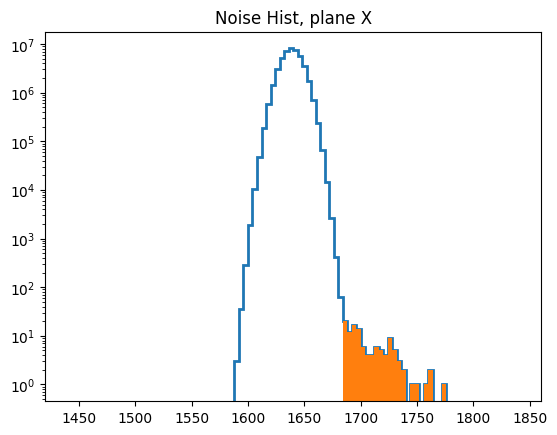

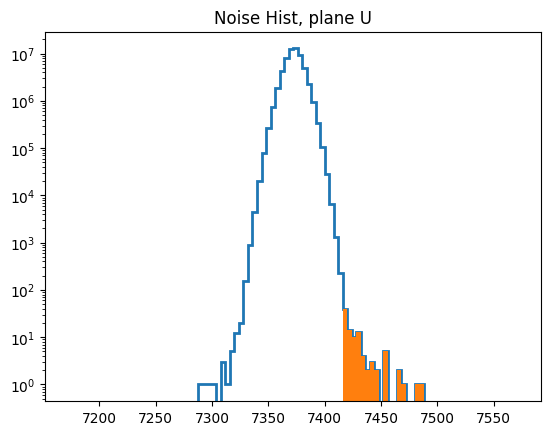

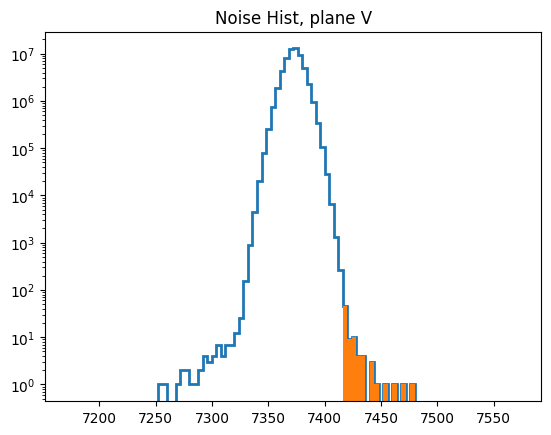

In [16]:
import mplhep as hep
import matplotlib.pyplot as plt

# ---

h = h_noise_x

fig, ax = plt.subplots()
thr = 45
m = (h.GetXaxis().FindBin(h.GetMean()))
p = (h.GetXaxis().FindBin(h.GetMean()+thr))

hep.histplot(h[m-50:m+50], label="noise plane x", linewidth=2, yerr=False, ax=ax)
hep.histplot(h[p:m+50], label="noise plane x", linewidth=2, yerr=False, ax=ax, histtype='fill')
ax.set_title("Noise Hist, plane X")
ax.set_yscale("log")

# ---

h = h_noise_u

fig, ax = plt.subplots()
thr = 42
m = (h.GetXaxis().FindBin(h.GetMean()))
p = (h.GetXaxis().FindBin(h.GetMean()+thr))

hep.histplot(h[m-50:m+50], label="noise plane u", linewidth=2, yerr=False, ax=ax)
hep.histplot(h_noise_u[p:m+50], label="noise plane u", linewidth=2, yerr=False, ax=ax, histtype='fill')
ax.set_title("Noise Hist, plane U")
ax.set_yscale("log")

# ---
h = h_noise_v

fig, ax = plt.subplots()
thr = 42
m = (h.GetXaxis().FindBin(h.GetMean()))
p = (h.GetXaxis().FindBin(h.GetMean()+thr))

hep.histplot(h[m-50:m+50], label="noise plane v", linewidth=2, yerr=False, ax=ax)
hep.histplot(h[p:m+50], label="noise plane v", linewidth=2, yerr=False, ax=ax, histtype='fill')
ax.set_title("Noise Hist, plane V")
ax.set_yscale("log")


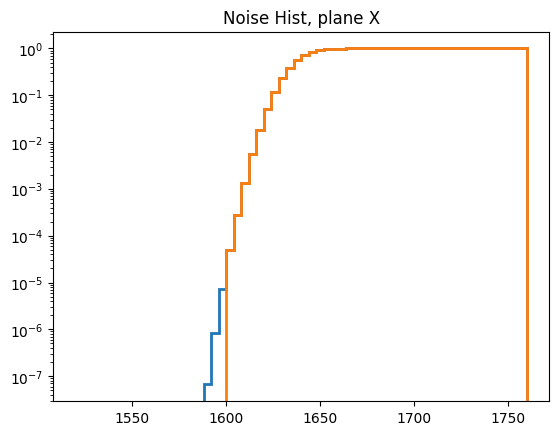

In [ ]:
fig, ax = plt.subplots()

hep.histplot(hx_int[380:440], label="noise plane x", linewidth=2, yerr=False, ax=ax)
hep.histplot(hx_int[400:440], label="noise plane x", linewidth=2, yerr=False, ax=ax)
ax.set_title("Noise Hist, plane X")
ax.set_yscale("log")
